In [55]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('/Users/praneeth/Downloads/Police_Department_Incidents.csv')

In [56]:
#DATA EXPLORATION
df.shape

(2191811, 13)

In [57]:
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [58]:
df.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
PdId            int64
dtype: object

In [59]:
#Checking if there are any missing values

df.isnull().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

In [60]:
#Fortunately, there is only one NAN in the column of PdDistrict. 
#We can use the location of this incident to infer which police station it was reported to.

In [61]:
df.Location[df.PdDistrict.isnull()]

1989195    (37.70820245849022, -122.4133519852842)
Name: Location, dtype: object

In [62]:
df.PdDistrict.fillna("INGLESIDE", inplace=True)

In [63]:
# Let's take look at the distribution of the incidents across the values in some columns.


In [64]:
df.Category.value_counts()

LARCENY/THEFT                  473791
OTHER OFFENSES                 306538
NON-CRIMINAL                   235649
ASSAULT                        192427
VEHICLE THEFT                  125966
DRUG/NARCOTIC                  118903
VANDALISM                      114676
WARRANTS                       100499
BURGLARY                        90486
SUSPICIOUS OCC                  79609
MISSING PERSON                  64324
ROBBERY                         55328
FRAUD                           41098
SECONDARY CODES                 25492
FORGERY/COUNTERFEITING          22935
WEAPON LAWS                     21988
TRESPASS                        19190
PROSTITUTION                    16669
STOLEN PROPERTY                 11770
SEX OFFENSES, FORCIBLE          11548
DISORDERLY CONDUCT               9987
DRUNKENNESS                      9781
RECOVERED VEHICLE                8716
DRIVING UNDER THE INFLUENCE      5628
KIDNAPPING                       5307
RUNAWAY                          4402
LIQUOR LAWS 

In [65]:
df.DayOfWeek.value_counts()


Friday       334368
Wednesday    320423
Saturday     317208
Thursday     312773
Tuesday      311868
Monday       303547
Sunday       291624
Name: DayOfWeek, dtype: int64

In [66]:
df.PdDistrict.value_counts()


SOUTHERN      395396
MISSION       296772
NORTHERN      269732
CENTRAL       223212
BAYVIEW       219012
INGLESIDE     192355
TENDERLOIN    190299
TARAVAL       165227
PARK          124199
RICHMOND      115607
Name: PdDistrict, dtype: int64

In [67]:
## Based on the map, SOUTHERN, MISSION, NORTHERN, CENTRAL stations basically cover the north-eastern part of SF. 
## As we will visulaize the data later, these are indeed the most dangerous areas.

In [68]:
df.Resolution.value_counts()


NONE                                      1372226
ARREST, BOOKED                             519332
ARREST, CITED                              154789
LOCATED                                     34463
PSYCHOPATHIC CASE                           29185
UNFOUNDED                                   23666
JUVENILE BOOKED                             14016
COMPLAINANT REFUSES TO PROSECUTE             8089
DISTRICT ATTORNEY REFUSES TO PROSECUTE       7955
NOT PROSECUTED                               7720
JUVENILE CITED                               6586
PROSECUTED BY OUTSIDE AGENCY                 5070
EXCEPTIONAL CLEARANCE                        4245
JUVENILE ADMONISHED                          3004
JUVENILE DIVERTED                             694
CLEARED-CONTACT JUVENILE FOR MORE INFO        686
PROSECUTED FOR LESSER OFFENSE                  85
Name: Resolution, dtype: int64

In [69]:
# Convert "Date" to a form of "yyyy-mm-dd" and create another column "Month"# Conver 
df.Date = df.Date.map(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
df['Month'] = df.Date.map(lambda x: int(x.split('-')[1]))

# Count the number of incidents in each month
# Since the 2018 is not over yet, we only use the 2003~2017 data
monthly_count = df.Month[df.Date < '2018'].value_counts()
monthly_count

10    190431
8     187368
3     186817
1     185541
5     184082
9     183389
7     181810
4     179509
11    174967
6     174736
12    170650
2     168655
Name: Month, dtype: int64

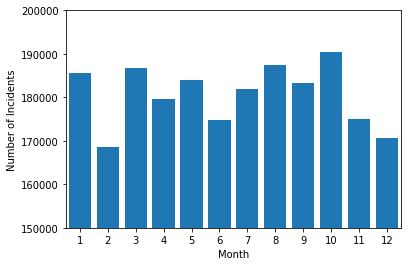

In [82]:
# make a bar plot
fig = plt.figure()
plt.bar(sorted(monthly_count.index), monthly_count.values[np.argsort(monthly_count.index)])
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xlim((0.5,12.5))
plt.ylim((150000,200000))
plt.xticks( np.arange(1,13) )
plt.show()

In [71]:
# Convert the time to floating point numbers between 0 and 24
df['Time_float'] = df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

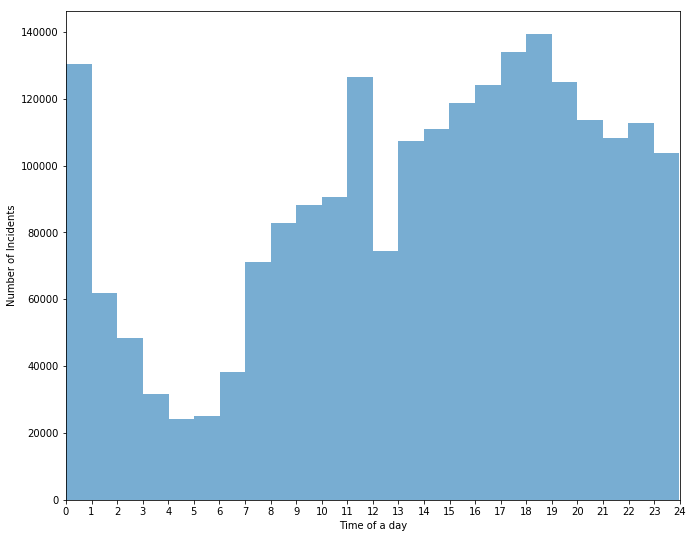

In [72]:
# make a histogram
fig = plt.figure()
plt.hist(df['Time_float'], bins=24, alpha = 0.6)
plt.xlabel('Time of a day')
plt.ylabel('Number of Incidents')
plt.xlim((0.0, 24))
plt.xticks( np.arange(0,25) )
plt.show()

In [75]:
########################## Spatial Distribution ###########################


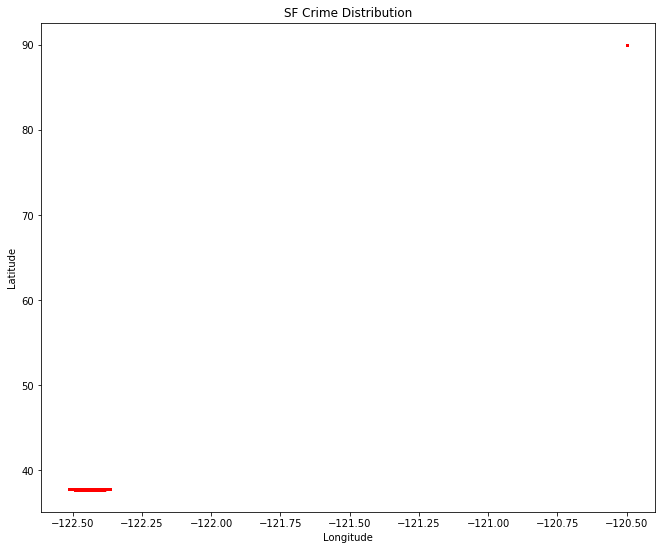

In [76]:
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 0.5, c = 'r')
plt.show()

In [77]:
# Ahh, so there is one point at (-120.5, 90)! 
# This is obviously a mistake made by the police department. Let's just remove this data point for better visualization.

In [78]:
df_new = df[df['Y'] < 80]

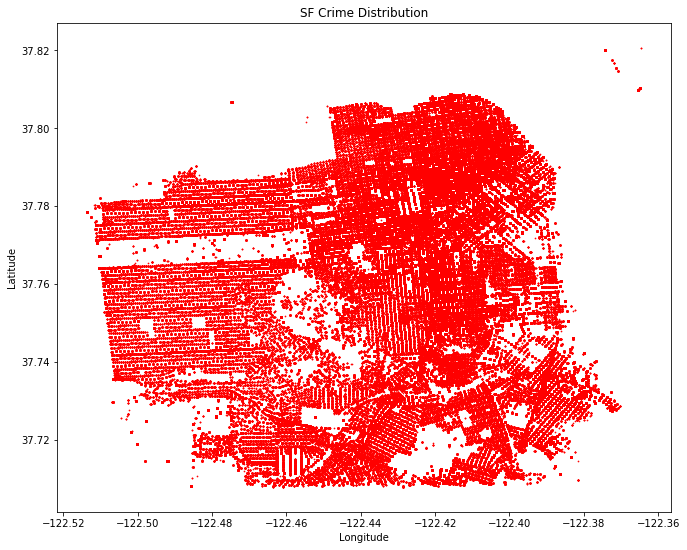

In [79]:
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df_new.X, df_new.Y, s = 0.5, c = 'r')
plt.show()

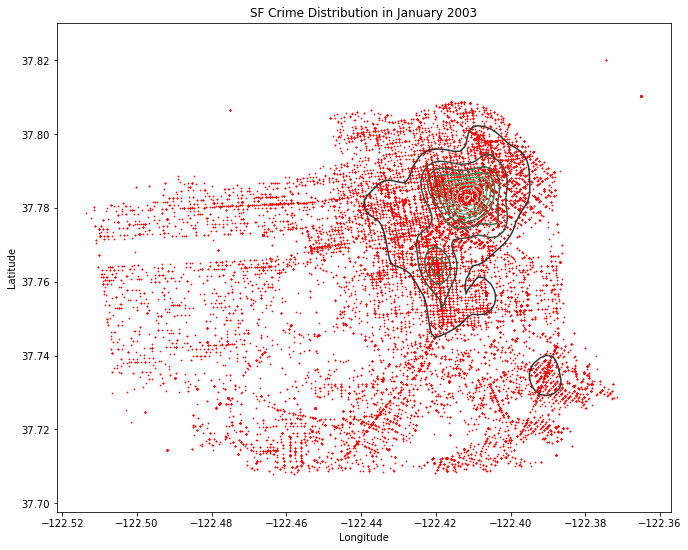

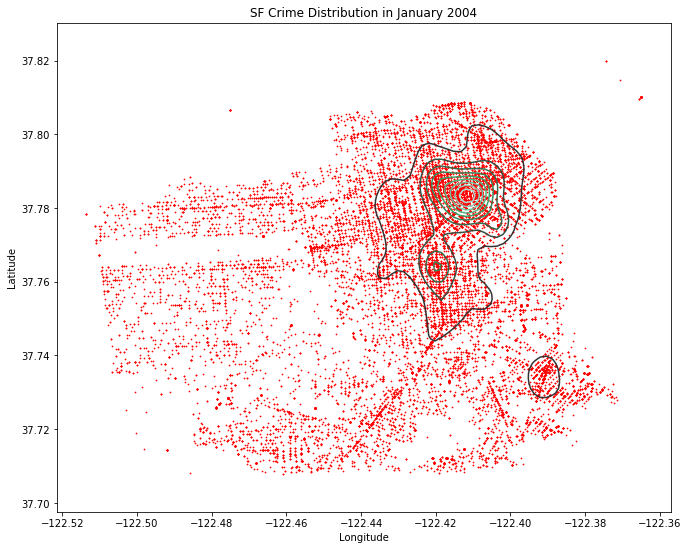

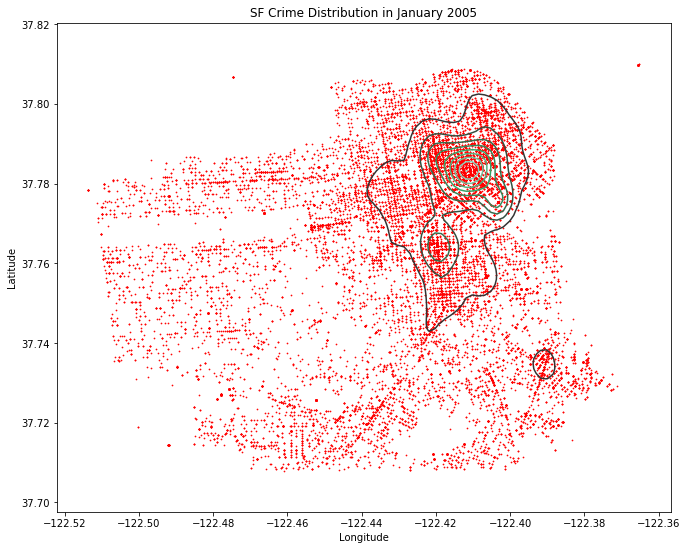

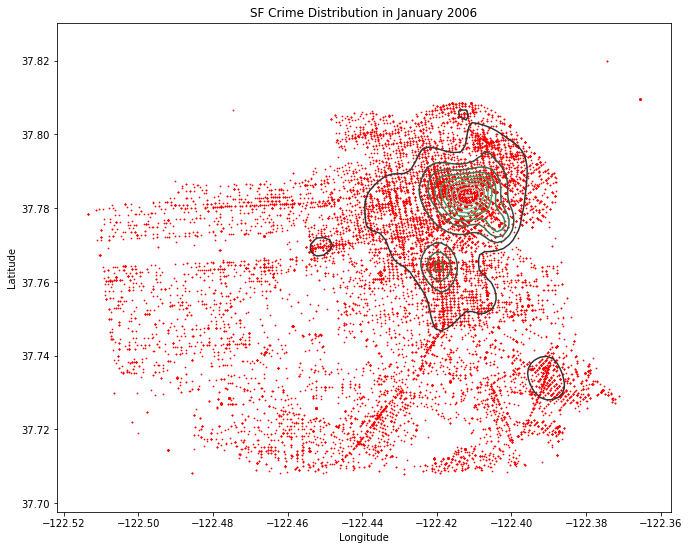

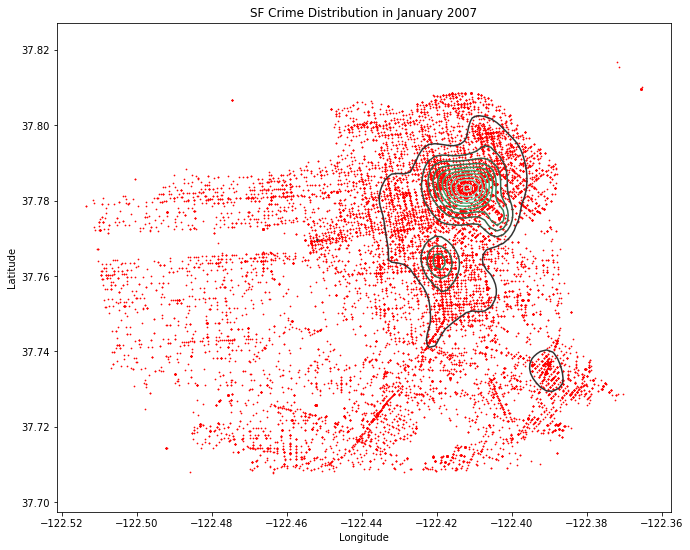

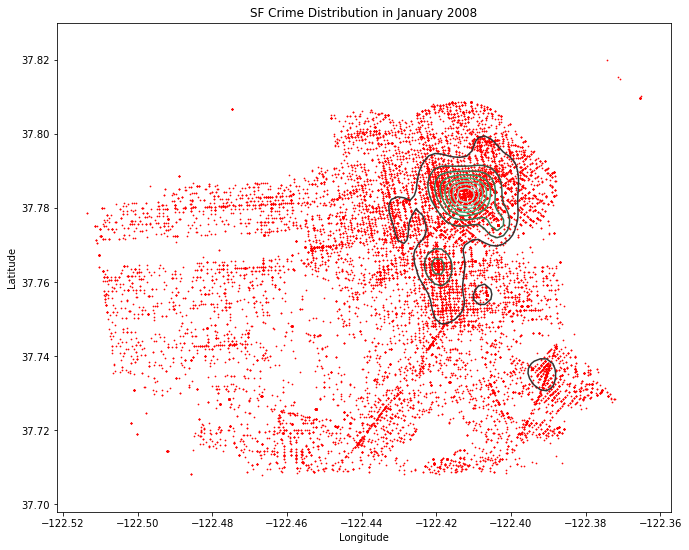

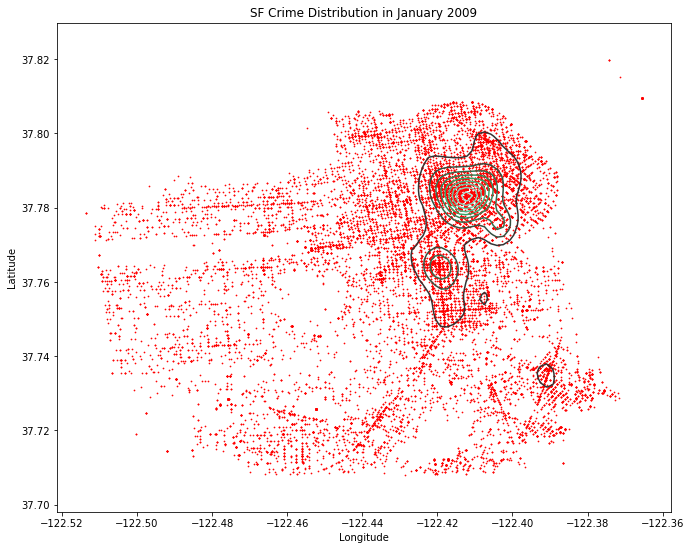

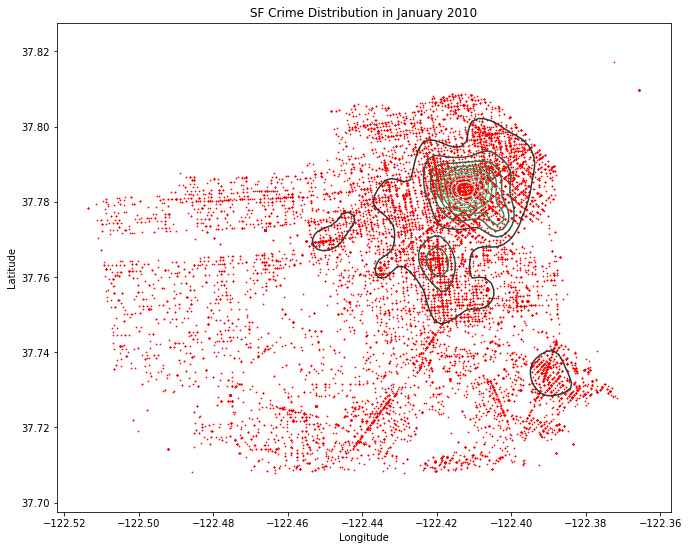

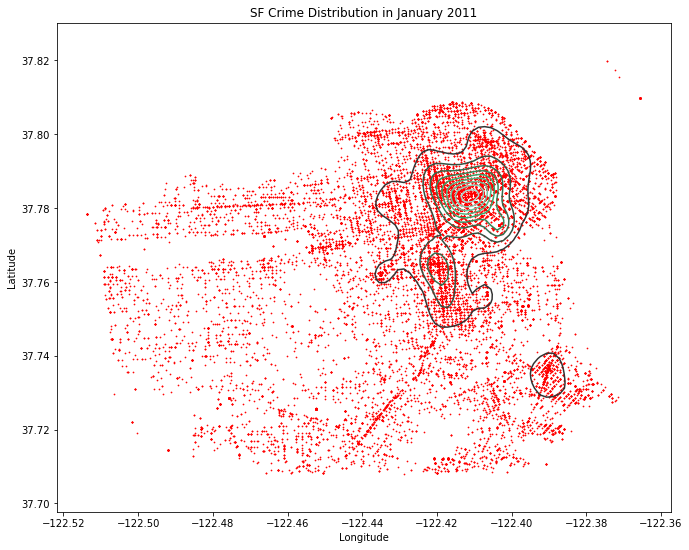

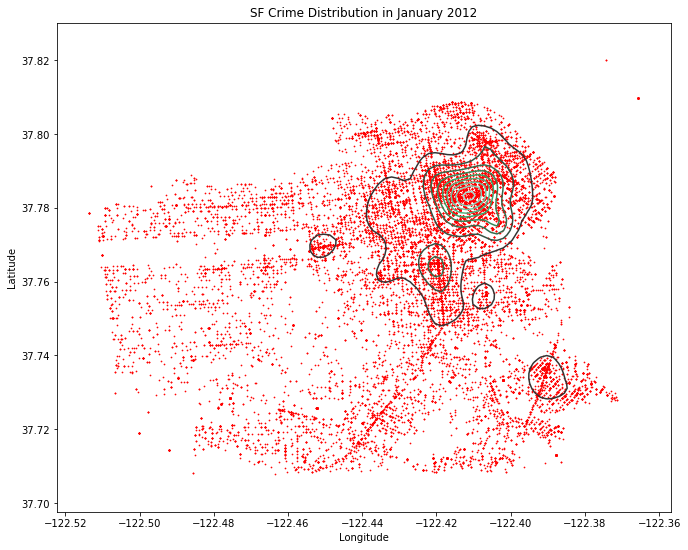

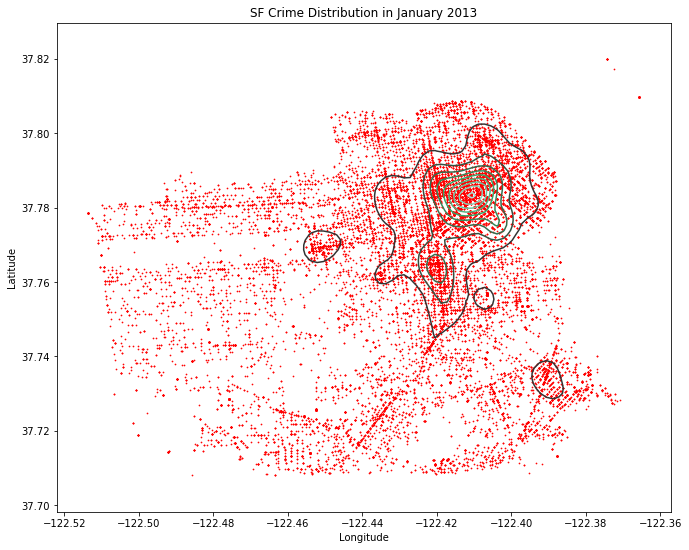

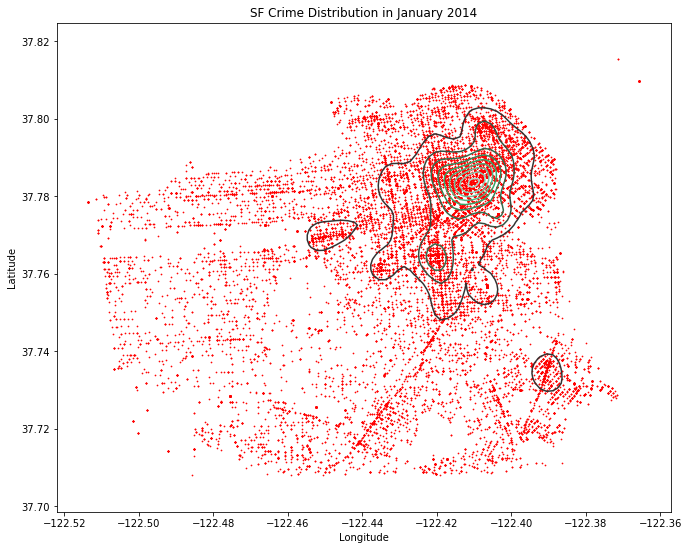

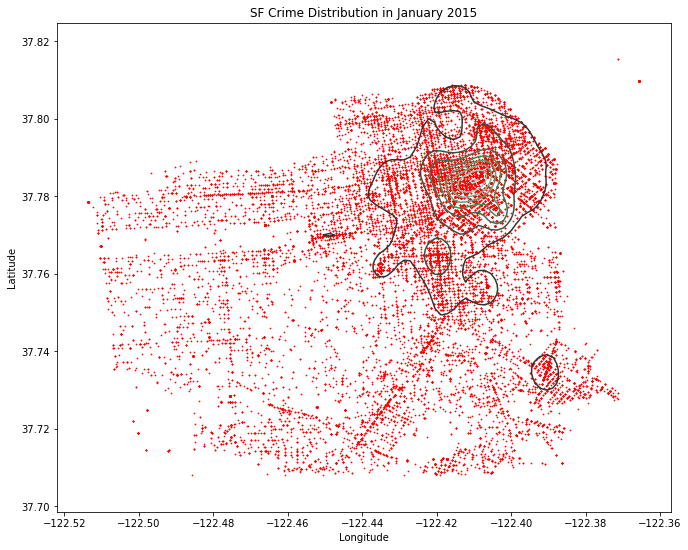

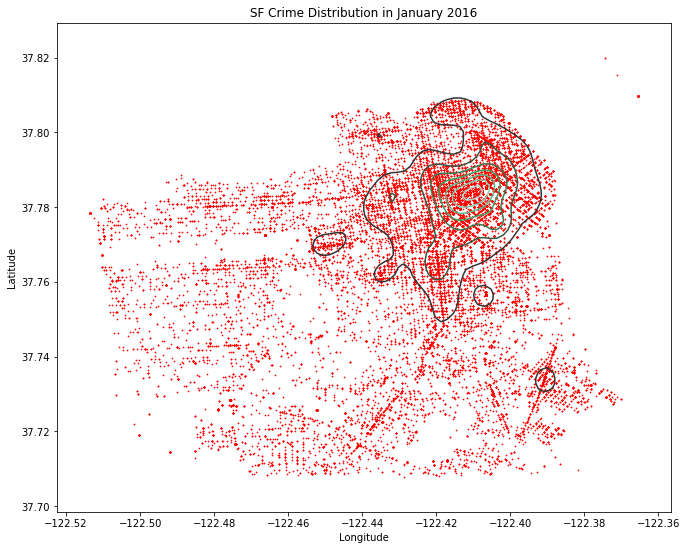

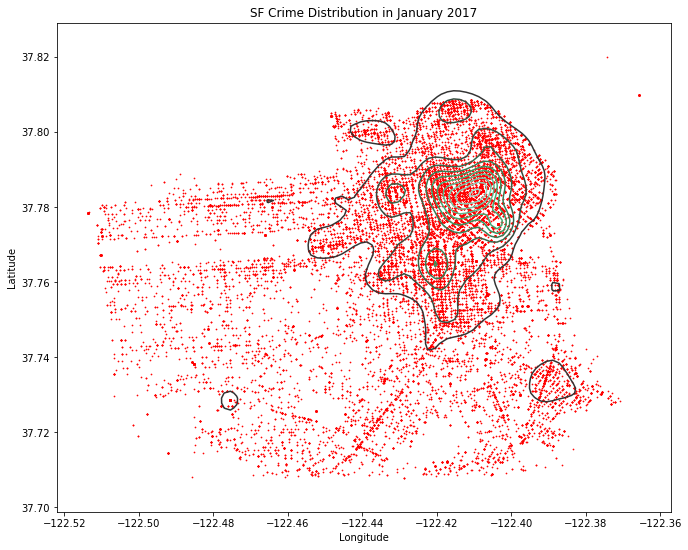

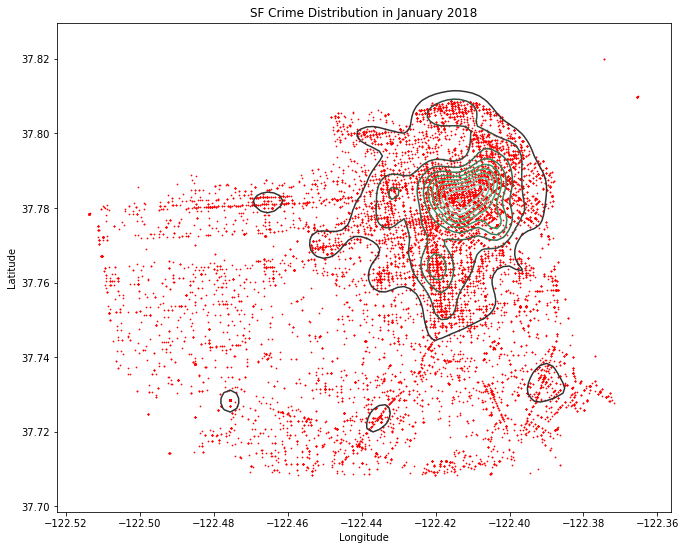

In [80]:
for yr in range(2003, 2019): 
    df_jan = df_new[(df_new['Date'] < str(yr) + '-02') & (df_new['Date'] > str(yr-1) + '-12-31')]
    fig = plt.figure()
    plt.title('SF Crime Distribution in January ' + str(yr))
    plt.scatter(df_jan.X, df_jan.Y, s = 0.5, c = 'r')
    sns.kdeplot(df_jan.X, df_jan.Y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [23]:
# So it looks like the north-eastern part of SF has always been the most dangerous area since 2003. 
# In addition, the contours show that the distribution of crimes around this area has expanded a bit toward 
# its west and south sides since 2015.

In [24]:
####################################### Time Series Analysis ################################


In [25]:
df.Date.min()

'2003-01-01'

In [26]:
df.Date.max()

'2018-04-02'

In [27]:
((pd.to_datetime('2018-02-18') - pd.to_datetime('2003-01-01')).days + 1)

5528

In [28]:
time_span = pd.date_range('2003-01-01', '2018-02-18')

# Convert a data frame to time series data
def df_to_TimeSeries(df):
    date = pd.to_datetime(df.Date.value_counts().index)
    index = sorted(date)
    data = df.Date.value_counts().values[np.argsort(date)]
    ts = pd.DataFrame(data = data, index = index, columns = ['count'])
    # if a date within the time span does not exist, fill it in with count = 0
    ts = ts.reindex(time_span, fill_value=0) 
    return ts

In [29]:
all_counts = df_to_TimeSeries(df)


In [30]:
# check if there is any date with count = 0
all_counts[all_counts['count'] == 0]

,count
2009-06-10,0


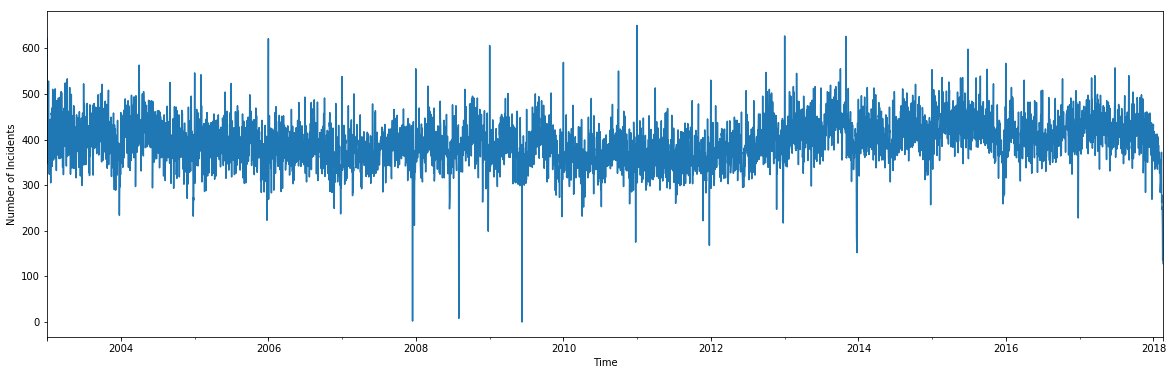

In [31]:
# plot the time series
fig = plt.figure(figsize=(20,6))
all_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of Incidents')
plt.show()

In [34]:
df_theft = df.loc[(df['Category'] == 'LARCENY/THEFT'), :]


In [35]:
theft_counts = df_to_TimeSeries(df_theft)


In [36]:
theft_counts[theft_counts['count'] == 0]


,count
2007-12-16,0
2009-06-10,0


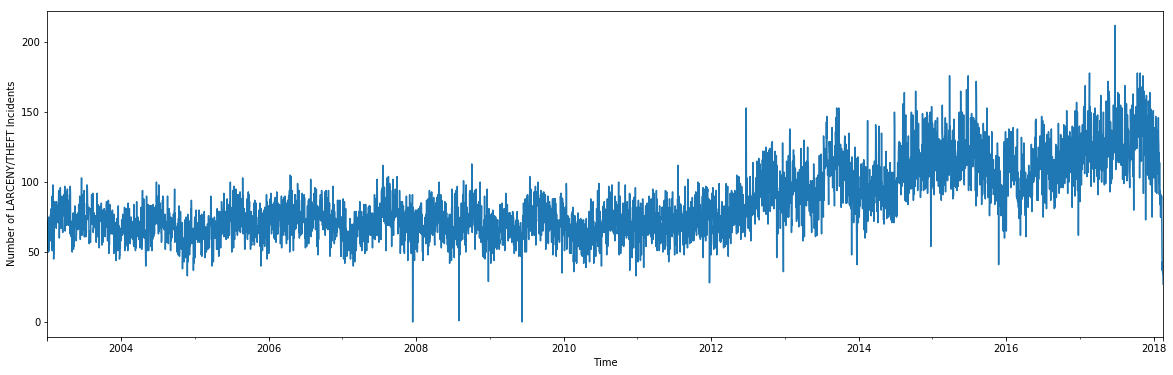

In [38]:
fig = plt.figure(figsize=(20,6))
theft_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of LARCENY/THEFT Incidents')
plt.show()

In [39]:
# All of these crime catagories can be further explored and modeled. 
# Here I will attempt to use a ARIMA model to fit the LARCENY/THEFT data. 
# To reduce the randomness of the data, we can bin the time series into monthly intervals. 
# This strategy is also good if there is a seasonal variation in the data, as 12 months equal a year. 
# Because one year is not a integer of weeks,
# using weekly intervals for a seasonal ARIMA model does not tend to give a good result.

In [40]:
y = theft_counts.resample('MS').sum()


In [41]:
y.tail()

,count
2017-10-01,4458
2017-11-01,4205
2017-12-01,4031
2018-01-01,3718
2018-02-01,1200


In [42]:
y = y[:-1]

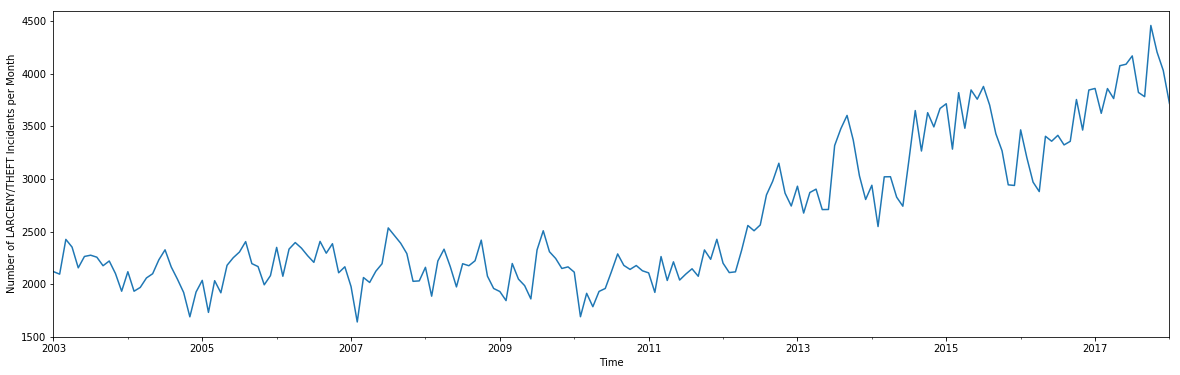

In [43]:
fig = plt.figure(figsize=(20,6))
y['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.show()

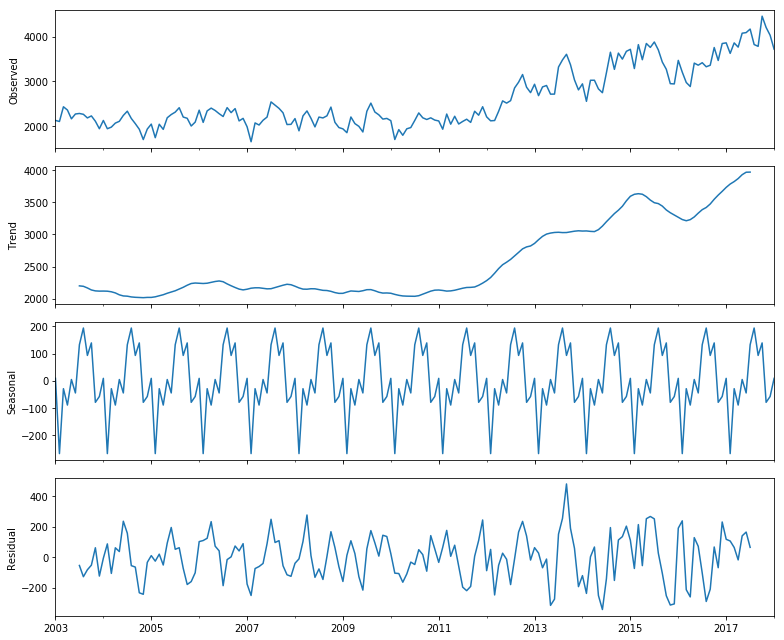

In [44]:
plt.rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [45]:
y_past, y_future = y[:-12], y[-12:]

In [46]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [47]:
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print ("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 1, 12): AIC = 2720.260483938272
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 12): AIC = 2113.7910535490364
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 0, 12): AIC = 2292.582110833784
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 1, 12): AIC = 2263.4074522956007
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 12): AIC = 2125.0980832293935
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 1, 12): AIC = 2111.0087187735135
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 0, 12): AIC = 2893.6573959095026
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 1, 12): AIC = 2542.5939992323256
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 0, 12): AIC = 2186.177723805912
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 12): AIC = 2014.1321874843138
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 0, 12): AIC = 2211.428504878889
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 1, 12): AIC = 2154.456792915519
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 12): AIC = 2036.041175994873
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 1, 12): AIC = 2009.4639782340364
(p,d,q,P,D,Q,S) = (0, 1, 0, 0, 0, 1, 12): AIC = 2099.080641160346
(p

In [48]:
print ("Best (p,d,q,P,D,Q,S) =", param)

Best (p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 1, 12)


In [49]:
results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6588,0.150,4.388,0.000,0.364,0.953
ma.L1,-0.8460,0.108,-7.804,0.000,-1.059,-0.634
ma.S.L12,-0.9932,1.301,-0.763,0.445,-3.544,1.558
sigma2,2.891e+04,3.62e+04,0.798,0.425,-4.21e+04,9.99e+04


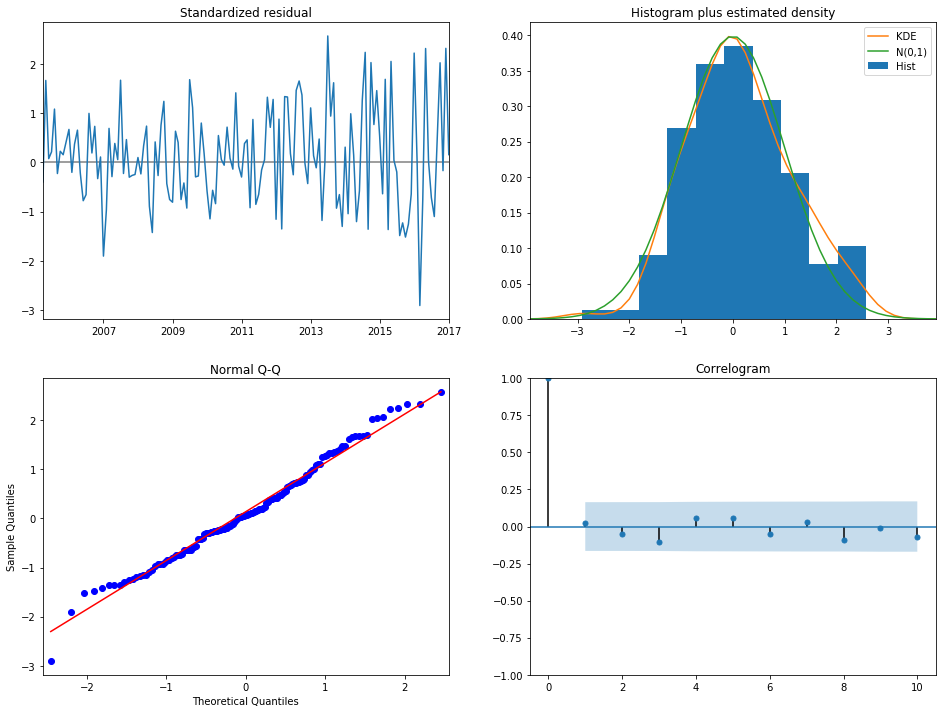

In [51]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y['count'].values[1:])
print ("-- Before taking the difference --")
print ("ADF Statistic:", result[0])
print ("p-value:", result[1])

diff = y.diff()
result = adfuller(diff['count'].values[1:])
print ("-- After taking the difference --")
print ("ADF Statistic:", result[0])
print ("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: 0.0428990786748
p-value: 0.96193925651
-- After taking the difference --
ADF Statistic: -4.05548520726
p-value: 0.00114627893139


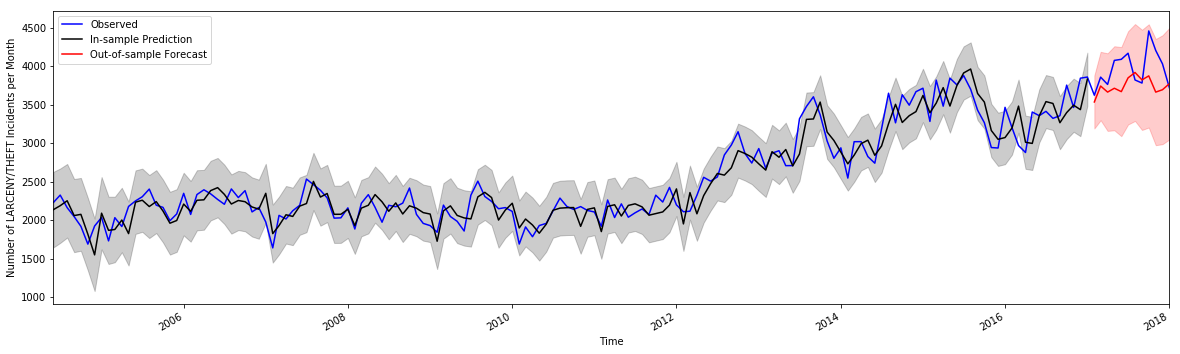

In [53]:
# neglect the beginning of the time series, where the model hasn't converged
pred = results.get_prediction(start = y_past['2004-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=12) # forecast for the next 12 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y['2004-06':].index, y['2004-06':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

In [54]:
#We do can see a discrepancy between the observed values and the model for the testing data. 
#However, they are still within a 95% confidence interval of the model prediction.